# Vehicle Detection & Tracking

The task in this project is to detect and track vehicles in images and videos.

To do this, we have to decide which features we'd like to extract out of the input images. Next, we have to train a classifier. Eventually, we have to test the algorithm on input images and video streams.

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Download libraries

In [16]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

from skimage.feature import hog

## Import Data

Images for training the classifier are divided up into vehicles & non-vehicles, and can be found in the folders `dataset_vehicles` and `dataset_non_vehicles`.

Images used for testing images can be found in the folder `test_images`.

Let's load them all.

Number of car images:  8792
Number of not-car images:  8968
Image shape:  (64, 64, 3)
Image data type:  <class 'numpy.ndarray'> ,  uint8


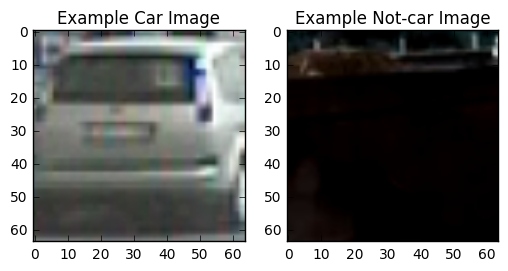

In [39]:
# Import all image paths for the images used to train the classifier
car_paths = glob.glob('dataset_vehicles/*/*.png')
not_car_paths = glob.glob('dataset_non_vehicles/*/*.png')
print('Number of car images: ', len(car_paths))
print('Number of not-car images: ', len(not_car_paths))
example_image = cv2.imread(car_paths[0])
print('Image shape: ', example_image.shape)
print('Image data type: ', type(example_image), ", ", example_image.dtype)

# Import all image paths for the images to test your classifier on
test_paths = glob.glob('test_images/*.jpg')

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(car_paths))
notcar_ind = np.random.randint(0, len(not_car_paths))
    
# Read in car / not-car images
car_image = cv2.imread(car_paths[car_ind])
notcar_image = cv2.imread(not_car_paths[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

## Feature Extraction: 
### Perform a Histogram of Oriented Gradients (HOG)

* Perform a HOG feature extraction on a labeled training set of images. 

(64, 64)


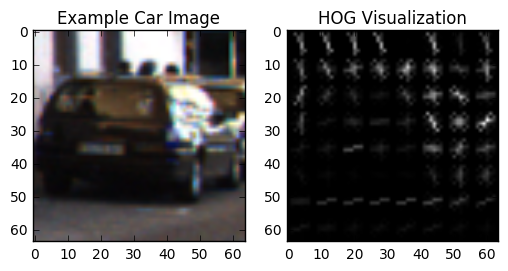

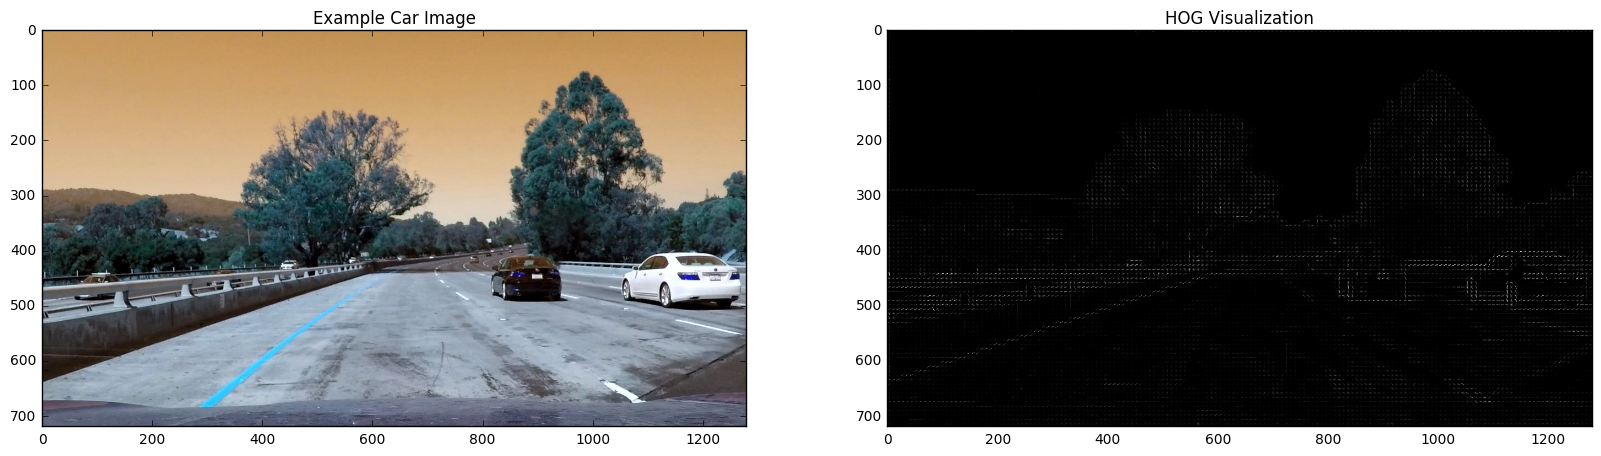

In [44]:
# Function returns HOG features and visualization
# orient: Number of orientation bins
# pix_per_cell: (2-tuple, (int, int)). Size of a cell (in pixels).
# cell_per_block: (2-tuple, (int, int)). Number of cells in each block.
# vis: bool. Return an image of the HOG?
# feature_vec: bool. Return the data as a feature vector by calling .ravel() on it?
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features, = hog(img, orientations=orient,
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block),
                        visualise=vis, feature_vector=feature_vec)
        return features
    
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_paths))
# Read in the image. Let's work with values between 0 to 255
image = cv2.imread(car_paths[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
print(gray.shape)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Get the HOG features and visualization
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

# Test it on a test image
image = cv2.imread(test_paths[0])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Get the HOG features and visualization
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize = (20, 20))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

If you look closely, you can recognize the cars in the HOG visualization! :D

##

## Train a linear Support Vector Machine (SVM) classifier

* Train a classifier to detect cars

## Sliding Window Search

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images

## Apply pipeline on a video stream

* Run your pipeline on a video stream
* Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.